# Convolutional Neural Network
## LeNet5

In [5]:
import torch
import torch.nn as nn

H, W = 28, 28
input_tensor = torch.randn(size=(1, 1,  H, W)) # B, C, H, W
tensor = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1)(input_tensor)
tensor = nn.Tanh()(tensor)
print(tensor.shape)

tensor = nn.AvgPool2d(kernel_size=2, stride=2)(tensor)
print(tensor.shape)

tensor = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)(tensor)
tensor = nn.Tanh()(tensor)
print(tensor.shape)

tensor = nn.AvgPool2d(kernel_size=2, stride=2)(tensor)
print(tensor.shape)

tensor = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)(tensor)
print(tensor.shape)

tensor = tensor.reshape(1, -1)
print(tensor.shape)

tensor = nn.Linear(in_features=120, out_features=84)(tensor)
tensor = nn.Tanh()(tensor)
print(tensor.shape)

tensor = nn.Linear(in_features=84, out_features=10)(tensor)
print(tensor.shape)

torch.Size([1, 6, 28, 28])
torch.Size([1, 6, 14, 14])
torch.Size([1, 16, 10, 10])
torch.Size([1, 16, 5, 5])
torch.Size([1, 120, 1, 1])
torch.Size([1, 120])
torch.Size([1, 84])
torch.Size([1, 10])


In [6]:
import torch
import torch.nn as nn
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1)
        self.tanh1 = nn.Tanh()

        self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.tanh2 = nn.Tanh()

        self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)

        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc1_act = nn.Tanh()
        
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.avg_pool1(x)
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.avg_pool2(x)
        x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc1_act(x)
        x = self.fc2(x)
        return x



In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


def get_dataset(BATCH_SIZE):
  dataset = MNIST(root='data', train=True, download=True, transform=ToTensor())
  N_DATA = len(dataset)
  data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)
  return data_loader, N_DATA

def get_device():
  if torch.cuda.is_available():DEVICE = 'cuda'
  elif torch.backends.mps.is_available(): DEVICE = 'mps'
  else: DEVICE = 'cpu'
  return DEVICE

def train(data_loader, model, loss_function, BATCH_SIZE, N_DATA, optimizer, DEVICE):
  epoch_loss, n_corrects = 0., 0
  for X, y in data_loader:
    X, y = X.to(DEVICE), y.to(DEVICE)
    X = X.reshape(BATCH_SIZE, 1, 28, 28)

    pred = model.forward(X)
    loss = loss_function(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * len(X)
    pred = torch.argmax(pred, dim=1)
    n_corrects += (pred == y).sum().item()

  epoch_loss /= N_DATA
  epoch_acc = n_corrects / N_DATA

  return epoch_loss, epoch_acc

def vis_losses_accs(losses, accs):
  fig, axes = plt.subplots(2, 1, figsize=(7, 14))
  axes[0].plot(losses)
  axes[0].set_ylabel('BCELoss')
  axes[1].plot(accs)
  axes[1].set_ylabel('Accuracy')
  axes[1].set_xlabel('Epoch')

100%|██████████| 50/50 [10:24<00:00, 12.49s/it]


Loss : 0.02032587238672034, Accuracy : 0.9943666666666666



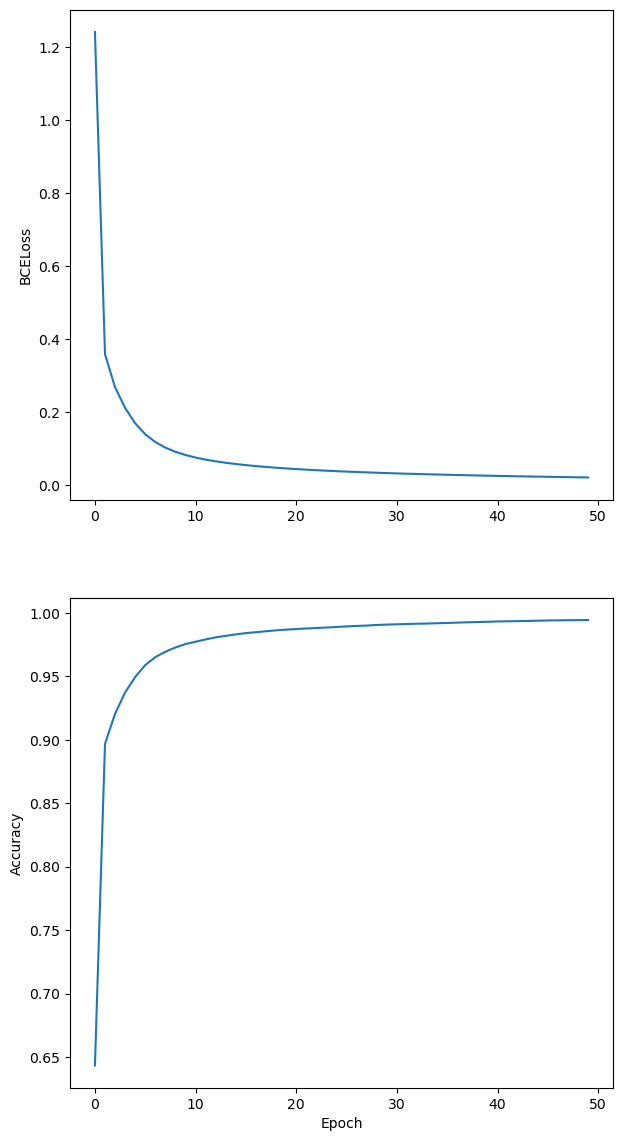

In [11]:
from torch.optim import SGD
from tqdm import tqdm

BATCH_SIZE = 32
EPOCHS = 50
LR = 0.01
pbar = tqdm(range(EPOCHS))

data_loader, N_DATA = get_dataset(BATCH_SIZE)
DEVICE = get_device()

model = Model().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

losses, accs = [], []
for epoch in pbar:
  epoch_loss, epoch_acc = train(data_loader, model, loss_function, BATCH_SIZE, N_DATA, optimizer, DEVICE)
  losses.append(epoch_loss)
  accs.append(epoch_acc)
pbar.close()

vis_losses_accs(losses, accs)
print(f'Loss : {losses[-1]}, Accuracy : {accs[-1]}\n')
